In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from conv_concept.model import ConvConcept
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Setup dataset and dataloader

In [3]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)

Training Setup

In [4]:
BATCH_LEN = 4 #still depends on its_til_update for true loss batch size
EPOCHS = 20

In [4]:
cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

NameError: name 'dataset' is not defined

In [5]:
model = ConvConcept()

Training utilities
# wow

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

NameError: name 'model' is not defined

Training loop definition

In [5]:
dir_to_save = 'conv_concept_models'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [7]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch):
    its_til_checkpoint = 20
    its_til_update = 4
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))

            running_loss = 0
            count = 0
            
        if i == 120: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [8]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

NameError: name 'cl_loader' is not defined

In [8]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch)
        print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
        plt.plot(epoch_losses, 'r-')
        plt.title('Epoch Losses')
        plt.show()
    
    return losses

In [9]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

In [10]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = ConvConcept()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
msssim = MS_SSIMLoss(channels=24)
l1 = torch.nn.L1Loss()
criterion = lambda pred, target: msssim(pred,target) #+ l1(pred,target) 

In [11]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

Entering epoch 0
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16


RuntimeError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 14.76 GiB total capacity; 13.45 GiB already allocated; 119.75 MiB free; 13.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### Lets see the results


tensor([[511.9976, 511.9999, 512.0074,  ..., 511.9926, 512.0045, 512.0049],
        [512.0040, 512.0115, 511.9956,  ..., 512.0129, 512.0027, 512.0102],
        [511.9926, 511.9919, 512.0137,  ..., 511.9817, 512.0045, 512.0085],
        ...,
        [512.0165, 511.9879, 511.9980,  ..., 512.0120, 511.9983, 511.9801],
        [512.0014, 511.9915, 512.0053,  ..., 511.9984, 512.0109, 511.9996],
        [512.0032, 512.0004, 511.9916,  ..., 512.0101, 512.0140, 512.0049]])
tensor([[511.9763, 512.0071, 511.9899,  ..., 512.0010, 512.0190, 512.0021],
        [511.9926, 512.0107, 512.0070,  ..., 512.0110, 512.0101, 512.0031],
        [511.9791, 511.9932, 511.9860,  ..., 512.0002, 511.9922, 511.9580],
        ...,
        [512.0060, 511.9889, 512.0007,  ..., 511.9813, 511.9907, 511.9977],
        [511.9928, 512.0111, 511.9860,  ..., 511.9973, 511.9899, 511.9968],
        [512.0005, 511.9943, 511.9990,  ..., 512.0028, 511.9990, 511.9945]])
tensor([[511.9984, 512.0084, 511.9741,  ..., 511.9997, 512.0

tensor([[511.9976, 511.9999, 512.0075,  ..., 511.9926, 512.0045, 512.0049],
        [512.0040, 512.0115, 511.9956,  ..., 512.0129, 512.0027, 512.0102],
        [511.9926, 511.9919, 512.0137,  ..., 511.9817, 512.0045, 512.0085],
        ...,
        [512.0165, 511.9879, 511.9980,  ..., 512.0120, 511.9983, 511.9801],
        [512.0014, 511.9915, 512.0053,  ..., 511.9983, 512.0109, 511.9996],
        [512.0032, 512.0004, 511.9916,  ..., 512.0101, 512.0140, 512.0049]])
tensor([[511.9763, 512.0071, 511.9899,  ..., 512.0010, 512.0190, 512.0021],
        [511.9926, 512.0107, 512.0070,  ..., 512.0110, 512.0101, 512.0031],
        [511.9791, 511.9932, 511.9860,  ..., 512.0003, 511.9922, 511.9580],
        ...,
        [512.0060, 511.9889, 512.0007,  ..., 511.9813, 511.9907, 511.9977],
        [511.9928, 512.0111, 511.9860,  ..., 511.9973, 511.9899, 511.9968],
        [512.0005, 511.9943, 511.9990,  ..., 512.0028, 511.9990, 511.9945]])
tensor([[511.9984, 512.0084, 511.9741,  ..., 511.9998, 512.0

tensor([[511.9976, 511.9999, 512.0075,  ..., 511.9926, 512.0045, 512.0049],
        [512.0040, 512.0115, 511.9956,  ..., 512.0129, 512.0027, 512.0102],
        [511.9926, 511.9919, 512.0137,  ..., 511.9817, 512.0045, 512.0085],
        ...,
        [512.0165, 511.9879, 511.9980,  ..., 512.0121, 511.9983, 511.9801],
        [512.0014, 511.9915, 512.0053,  ..., 511.9984, 512.0109, 511.9997],
        [512.0032, 512.0004, 511.9916,  ..., 512.0101, 512.0140, 512.0049]])
tensor([[511.9763, 512.0071, 511.9899,  ..., 512.0010, 512.0190, 512.0021],
        [511.9926, 512.0107, 512.0070,  ..., 512.0110, 512.0101, 512.0031],
        [511.9791, 511.9932, 511.9860,  ..., 512.0002, 511.9922, 511.9580],
        ...,
        [512.0060, 511.9888, 512.0007,  ..., 511.9813, 511.9907, 511.9977],
        [511.9928, 512.0111, 511.9860,  ..., 511.9973, 511.9899, 511.9968],
        [512.0005, 511.9943, 511.9990,  ..., 512.0028, 511.9990, 511.9945]])
tensor([[511.9984, 512.0084, 511.9741,  ..., 511.9998, 512.0

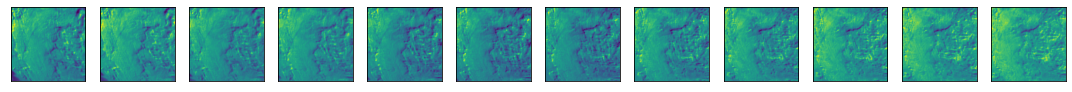

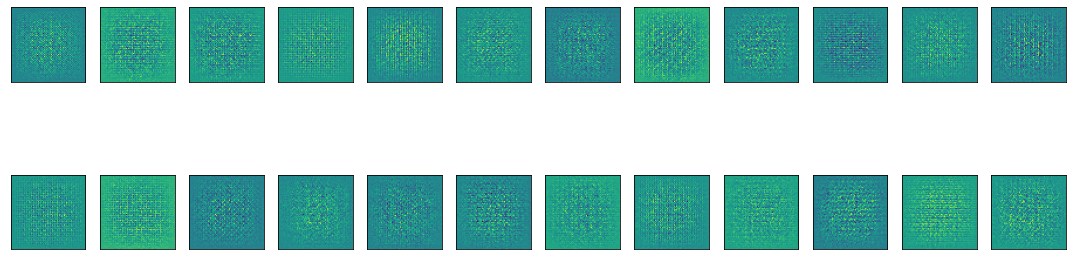

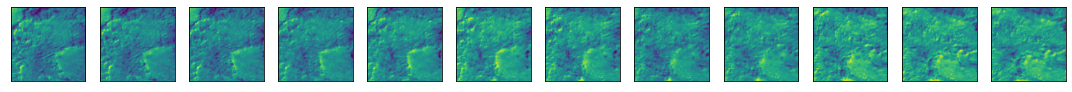

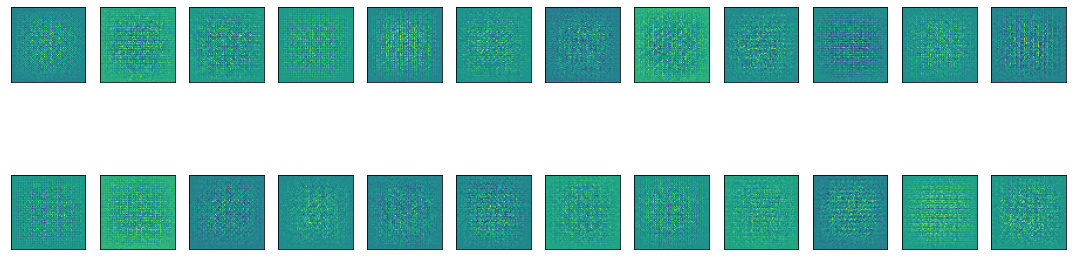

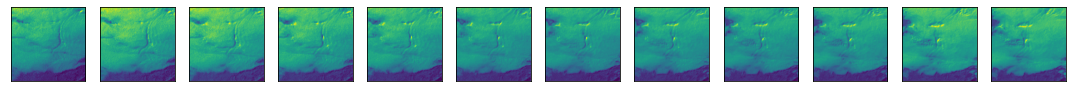

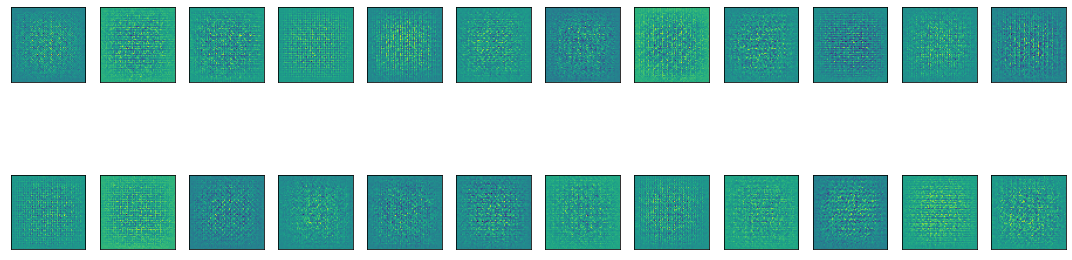

In [10]:
model.eval()
garbo = [dataset[i] for i in range(10, 13)]
for i, (features, targets) in enumerate(garbo):
    if i == 3:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            print(predictions[p_no])
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()